## BIOINFORMATICS THESIS: MULTIMODAL NEURAL NETWORK

In [1]:
import pandas as pd 
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, OrderedDict
import pickle

import sqlite3
from sqlalchemy import create_engine

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS

In [3]:
from BIOINF_tesi.data_pipe import Load_Create_Task
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline

In [4]:
from BIOINF_tesi.models import FFNN, CNN, CNN_LSTM
from BIOINF_tesi.models.utils import fit, Param_Search, Kfold_CV

In [5]:
with open ('results_dict.pickle', 'rb') as fin:
    results_dict = pickle.load(fin)
    results_dict = defaultdict(lambda: defaultdict(dict), results_dict)

In [6]:
from BIOINF_tesi.visual import print_content_results_dict

In [9]:
print_content_results_dict('EmbraceNetMultimodal_augm')

A549

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


GM12878

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


H1

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


HEK293

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_E

---

In [7]:
from BIOINF_tesi.visual import get_average_AUPRC_df

df = get_average_AUPRC_df(models=['FFNN','CNN','EmbraceNetMultimodal','ConcatNetMultimodal',
                                 'EmbraceNetMultimodal_augm'])

for model in df.keys():
    print(model)
    display(df[model])

FFNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.10027,0.24168,0.68156,0.51327,0.20868
GM12878,0.42034,0.34351,0.83981,0.5634,0.27437
H1,0.14697,0.22636,0.52994,0.57539,0.2646
HEK293,0.15953,0.31676,0.80595,0.55786,0.21084
HEPG2,0.28804,0.28613,0.75434,0.59386,0.30491
K562,0.17202,0.34186,0.78795,0.58864,0.25344
MCF7,0.1509,0.32017,0.76951,0.56793,0.24546


CNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.06011,0.19374,0.65774,0.58422,0.14678
GM12878,0.20147,0.23723,0.78504,0.55978,0.20721
H1,0.08377,0.20219,0.33909,0.5997,0.19009
HEK293,0.11423,0.24028,0.60146,0.45543,0.20859
HEPG2,0.12415,0.24769,0.68355,0.57477,0.19717
K562,0.09604,0.24245,0.64967,0.56412,0.16921
MCF7,0.08775,0.19941,0.55164,0.45291,0.17418


EmbraceNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.10933,0.24523,0.67179,0.57709,0.16442
GM12878,0.3434,0.34666,0.71726,0.55977,0.22973
H1,0.05375,0.23098,0.41866,0.56326,0.21831
HEK293,0.11604,0.29244,0.62615,0.56287,0.20273
HEPG2,0.29211,0.35539,0.75288,0.57384,0.17412
K562,0.10981,0.33587,0.76434,0.57377,0.17803
MCF7,0.08383,0.25756,0.54421,0.59234,0.17586


ConcatNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.0996,0.16468,0.57216,0.59152,0.17485
GM12878,0.37574,0.29635,0.76488,0.54756,0.28359
H1,0.06441,0.29486,0.42564,0.58151,0.22755
HEK293,0.14064,0.26546,0.80586,0.58561,0.17691
HEPG2,0.18464,0.2446,0.6616,0.59477,0.25679
K562,0.11477,0.31197,0.63634,0.59153,0.22964
MCF7,0.08323,0.2504,0.76525,0.59242,0.24137


EmbraceNetMultimodal_augm


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.09038,0.20377,0.67142,0.58066,0.20766
GM12878,0.26883,0.27028,0.67502,0.56361,0.31847
H1,0.15266,0.24426,0.29897,0.58075,0.24059
HEK293,0.12528,0.23461,0.8063,0.57779,0.22275
HEPG2,0.25514,0.3598,0.74389,0.56855,0.24777
K562,0.13716,0.29783,0.78494,0.5375,0.22142
MCF7,0.14127,0.25751,0.76228,0.5887,0.24044


---

In [8]:
from BIOINF_tesi.visual import plot_scores
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS

## 1) A549

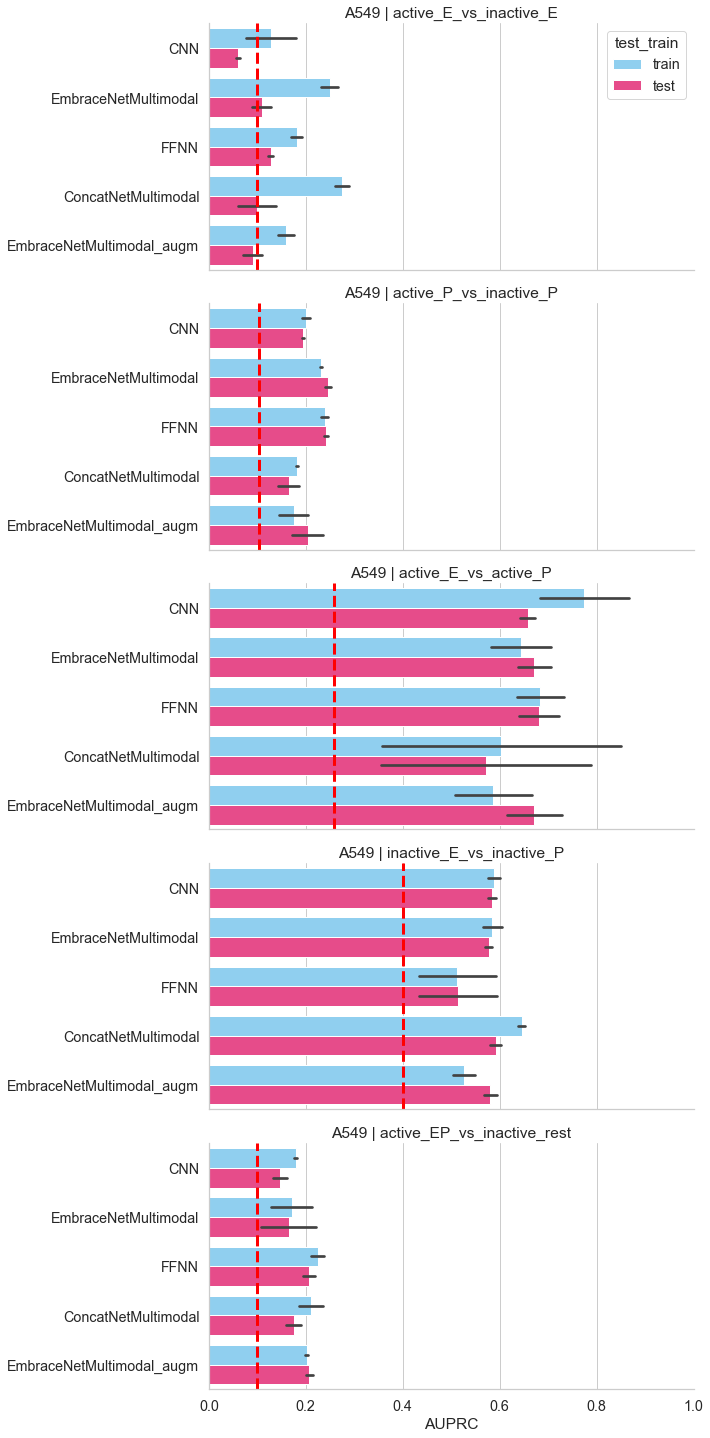

In [12]:
cell_line = CELL_LINES[0]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'],
            palette=0)

## 2) GM12878

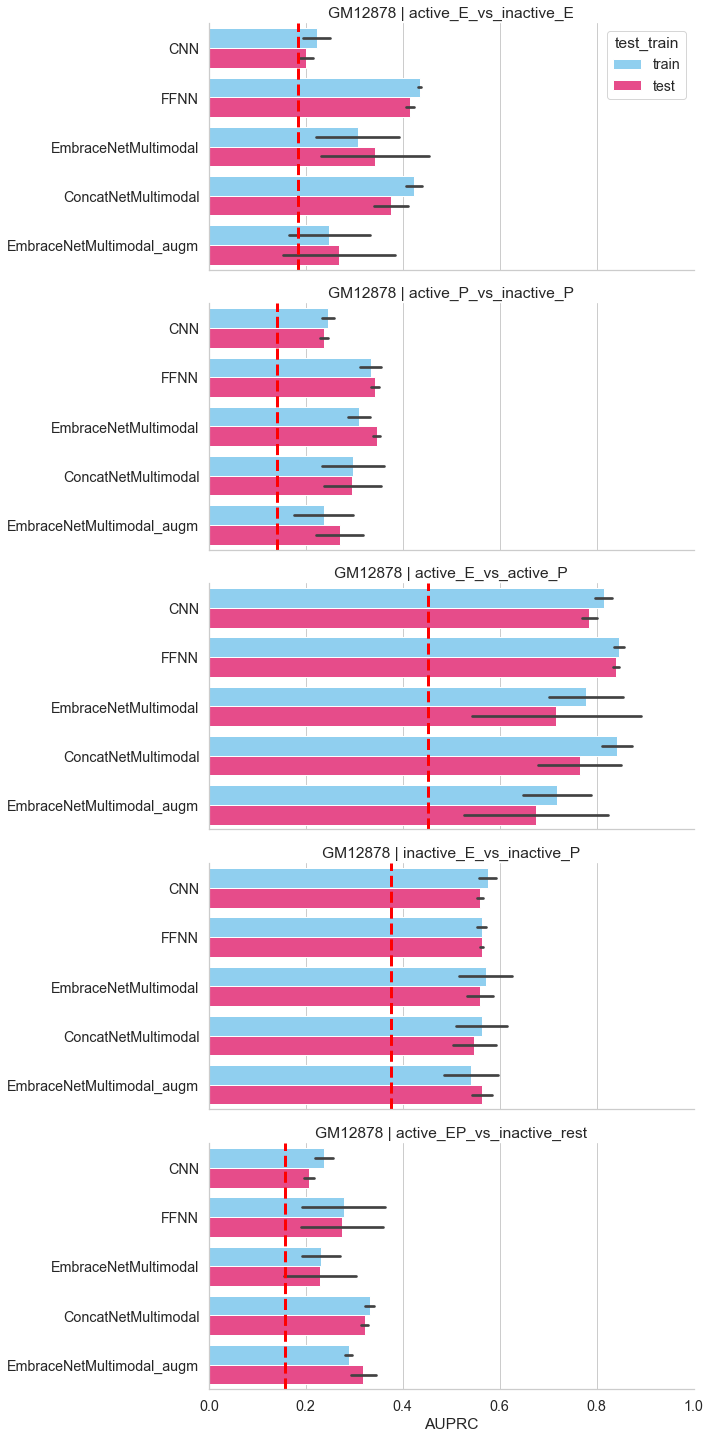

In [13]:
cell_line = CELL_LINES[1]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 3) H1

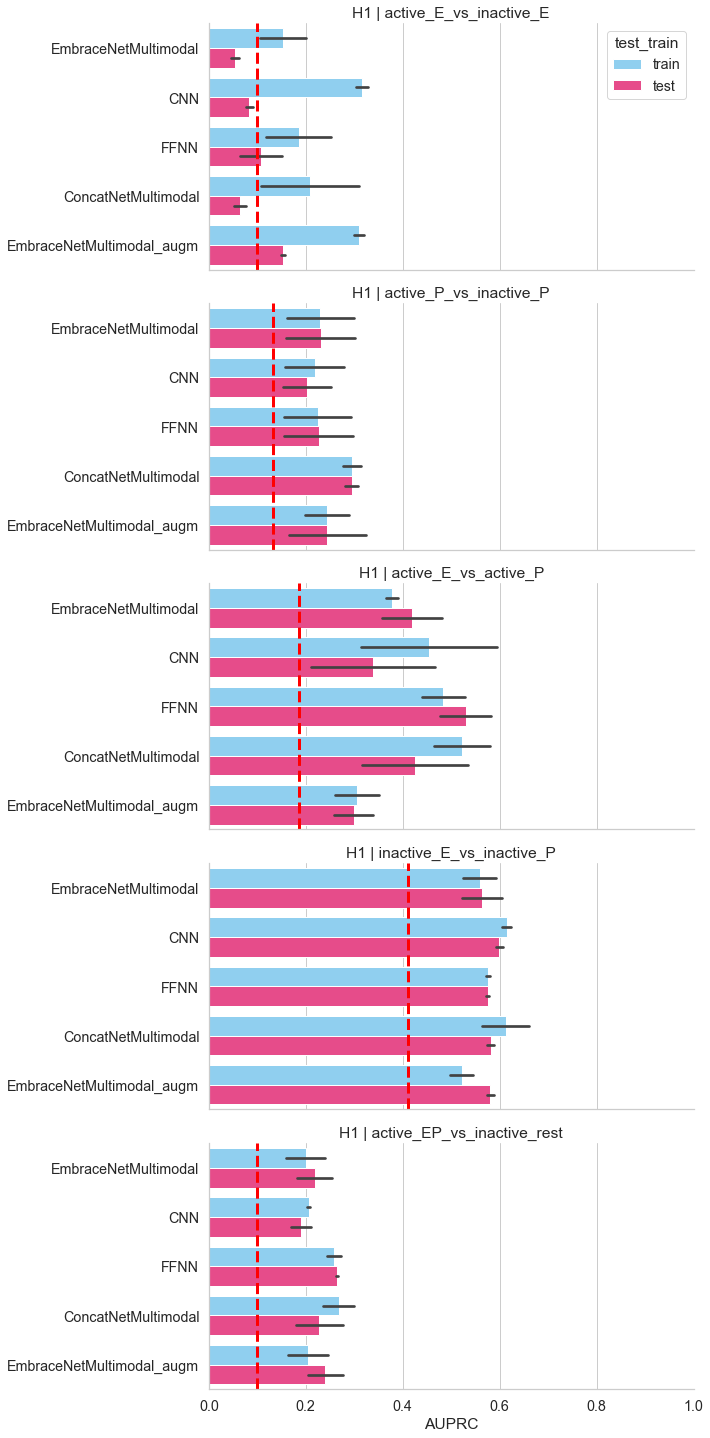

In [14]:
cell_line = CELL_LINES[2]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 4) HEK293

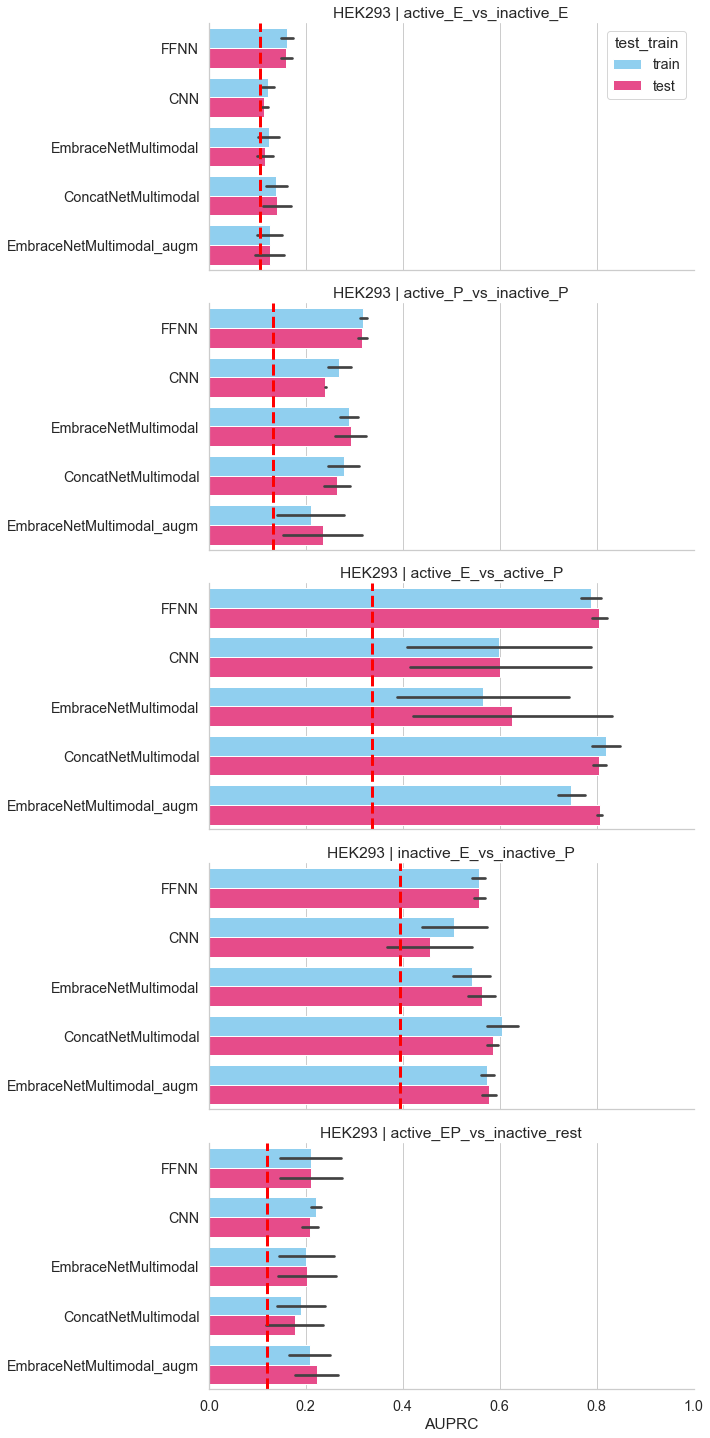

In [15]:
cell_line = CELL_LINES[3]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 5) HEPG2

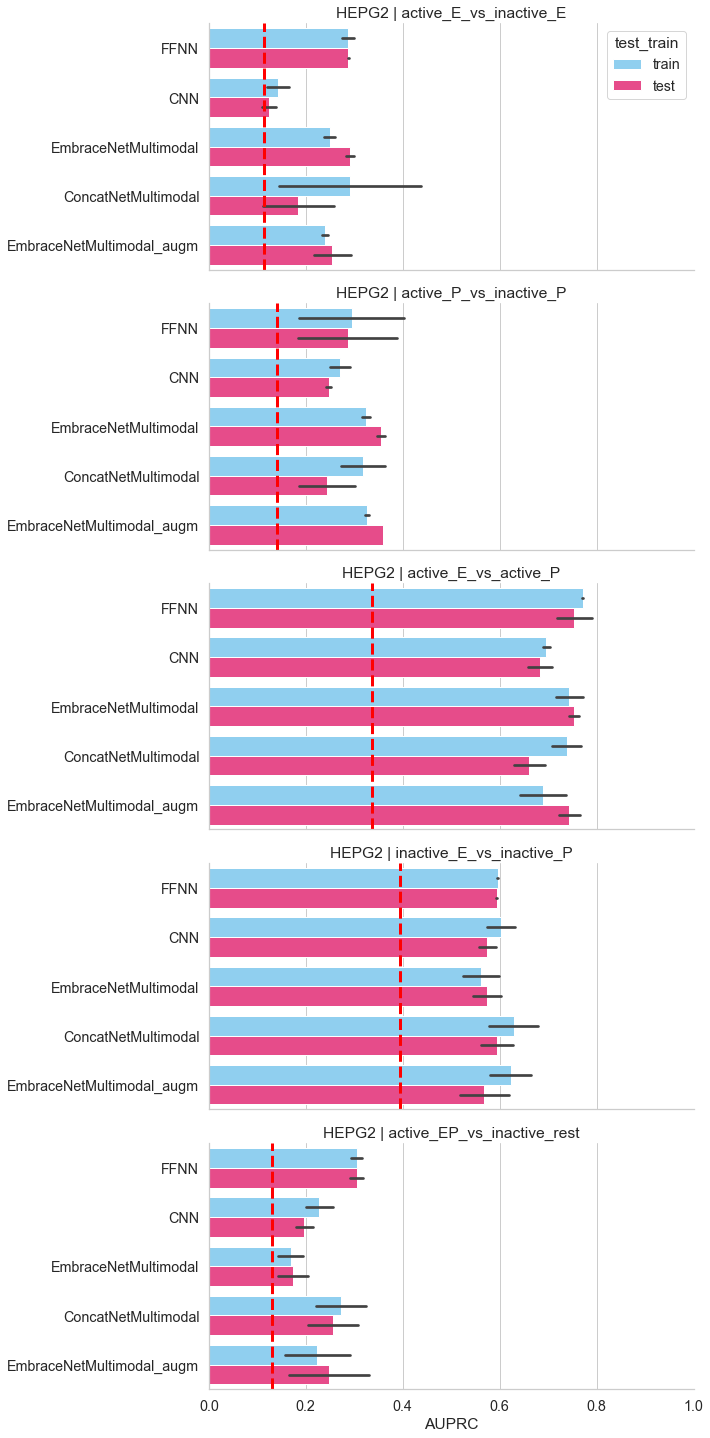

In [16]:
cell_line = CELL_LINES[4]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 6) K562

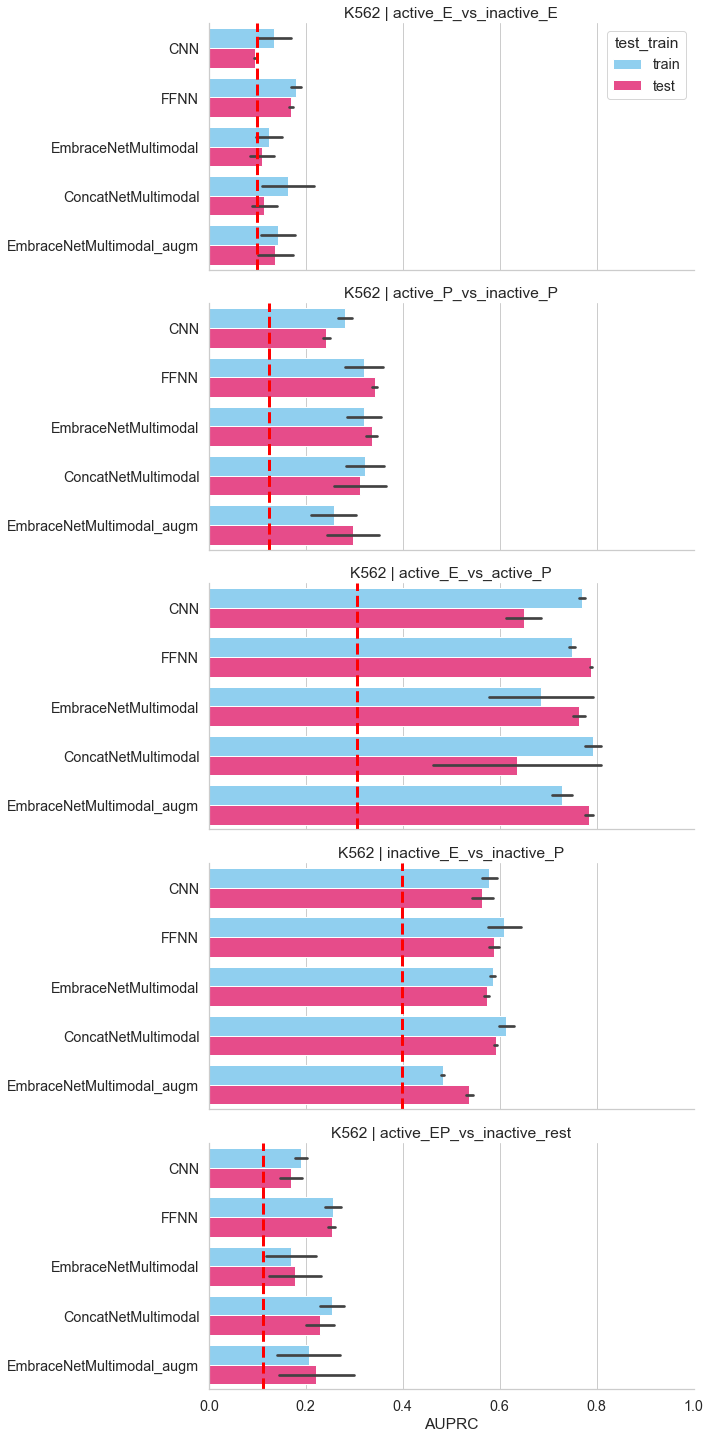

In [17]:
cell_line = CELL_LINES[5]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 7) MCF7

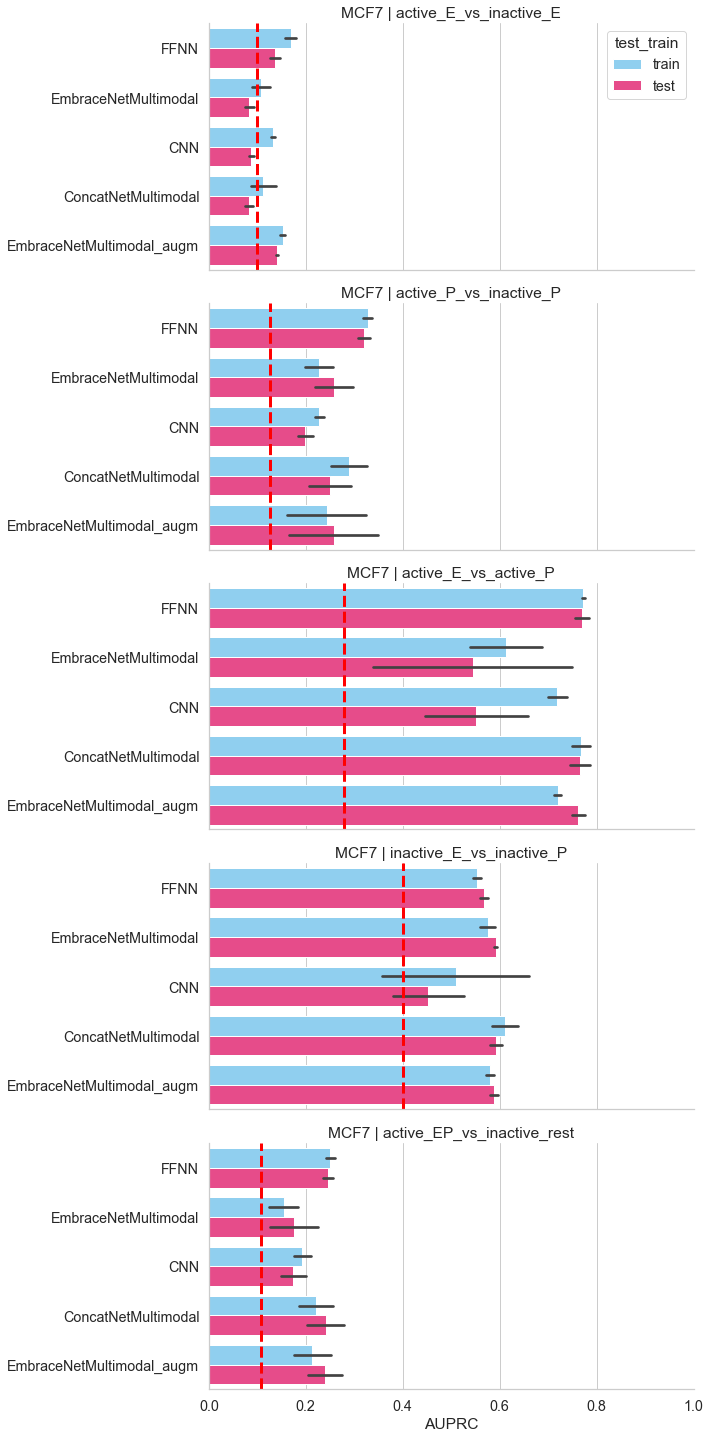

In [18]:
cell_line = CELL_LINES[6]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

---

In [ ]:
from BIOINF_tesi.visual import Compare_Models_Result

compare_models = Compare_Models_Result()
pval_dict = compare_models(device)

Iter tasks:   0%|          | 0/5 [00:00<?, ?it/s]

Data Preprocessing Done!


Iter cell lines:   0%|          | 0/7 [00:00<?, ?it/s]

Iter folds:   0%|          | 0/3 [00:00<?, ?it/s]

iter models:   0%|          | 0/2 [00:00<?, ?it/s]

iter models:   0%|          | 0/2 [00:00<?, ?it/s]

iter models:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
for task in pval_dict.keys():
    for cell_line in pval_dict[task].keys():
        for b_model in pval_dict[task][cell_line].keys():
            for c_model in pval_dict[task][cell_line][b_model].keys():
                counter = 0
                
                for fold in pval_dict[task][cell_line][b_model][c_model].keys():
                    if pval_dict[task][cell_line][b_model][c_model][fold] >=0.05:
                        pval_dict[task][cell_line][b_model][c_model][fold]['different']=False
                    else:
                        pval_dict[task][cell_line][b_model][c_model][fold]['different']=True
                        counter +=1
                if counter >=2:
                    pval_dict[task][cell_line][b_model][c_model]['different']=True